## Logistic Regression analysis:Iris dataset


--- 1. Impact of Custom Thresholds ---
   Threshold  Accuracy  Precision    Recall
0        0.1  0.488889   0.361111  1.000000
1        0.2  0.600000   0.407407  0.846154
2        0.3  0.688889   0.470588  0.615385
3        0.4  0.711111   0.500000  0.461538
4        0.5  0.733333   0.571429  0.307692
5        0.6  0.733333   0.666667  0.153846
6        0.7  0.733333   1.000000  0.076923
7        0.8  0.711111   0.000000  0.000000
8        0.9  0.711111   0.000000  0.000000

--- 2. Analysis for Other Columns (Individual Features) ---

--- Analyzing feature: sepal length (cm) ---
   Threshold  Accuracy  Precision  Recall
0        0.1  0.288889   0.288889     1.0
1        0.2  0.288889   0.288889     1.0
2        0.3  0.288889   0.288889     1.0
3        0.4  0.711111   0.000000     0.0
4        0.5  0.711111   0.000000     0.0
5        0.6  0.711111   0.000000     0.0
6        0.7  0.711111   0.000000     0.0
7        0.8  0.711111   0.000000     0.0
8        0.9  0.711111   0.000000  

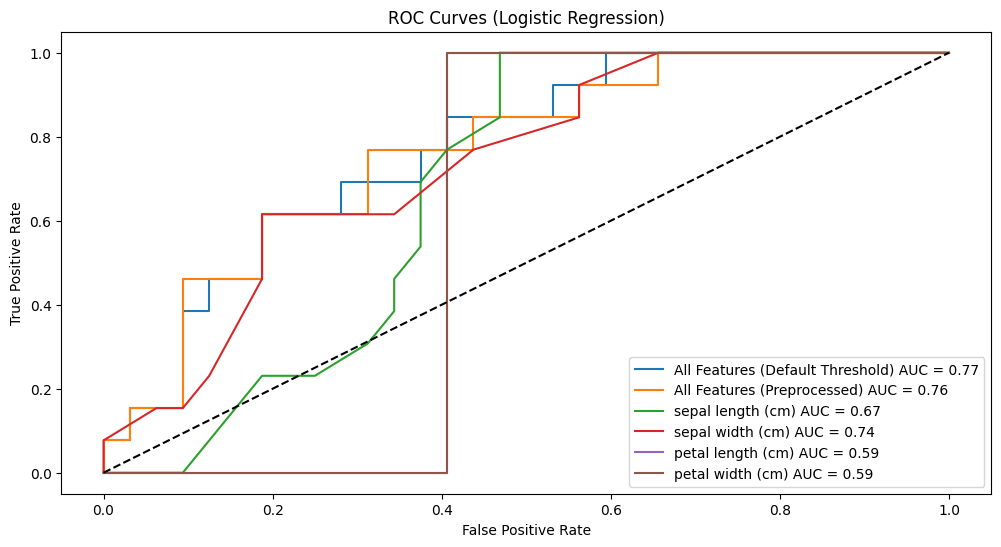

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris(as_frame=True)
df = iris.frame

# The target variable is 'target' (0, 1, or 2 for different Iris species).
# For binary classification, let's create a new target:
# 'versicolor' (1) vs. 'not versicolor' (0)
df['is_versicolor'] = (df['target'] == 1).astype(int)
target_column_name = 'is_versicolor'

# Separate features (X) and target (y)
X = df.drop(columns=['target', target_column_name])
y = df[target_column_name]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 1. Impact of Custom Thresholds ---
print("\n--- 1. Impact of Custom Thresholds ---")
model_default = LogisticRegression()
model_default.fit(X_train, y_train)
probabilities_default = model_default.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1, 0.1)
results_thresholds = []
for threshold in thresholds:
    predictions = (probabilities_default >= threshold).astype(int)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0) # Handle potential division by zero
    recall = recall_score(y_test, predictions, zero_division=0)     # Handle potential division by zero
    results_thresholds.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    })

print(pd.DataFrame(results_thresholds))

# --- 2. Analysis for Other Columns (Individual Features) ---
print("\n--- 2. Analysis for Other Columns (Individual Features) ---")
for column in X.columns:
    print(f"\n--- Analyzing feature: {column} ---")
    X_single = X[[column]]
    X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
        X_single, y, test_size=0.3, random_state=42
    )
    model_single = LogisticRegression()
    model_single.fit(X_train_single, y_train_single)
    probabilities_single = model_single.predict_proba(X_test_single)[:, 1]

    results_single_thresholds = []
    for threshold in thresholds:
        predictions_single = (probabilities_single >= threshold).astype(int)
        accuracy_single = accuracy_score(y_test_single, predictions_single)
        precision_single = precision_score(y_test_single, predictions_single, zero_division=0)
        recall_single = recall_score(y_test_single, predictions_single, zero_division=0)
        results_single_thresholds.append({
            'Threshold': threshold,
            'Accuracy': accuracy_single,
            'Precision': precision_single,
            'Recall': recall_single
        })
    print(pd.DataFrame(results_single_thresholds))

# --- 3. Logistic Regression Model on All Features (with Preprocessing) ---
print("\n--- 3. Logistic Regression Model on All Features (with Preprocessing) ---")
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model_all_features = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(solver='liblinear'))])

model_all_features.fit(X_train, y_train)
y_pred_all = model_all_features.predict(X_test)
probabilities_all = model_all_features.predict_proba(X_test)[:, 1]
accuracy_all = accuracy_score(y_test, y_pred_all)
precision_all = precision_score(y_test, y_pred_all, zero_division=0)
recall_all = recall_score(y_test, y_pred_all, zero_division=0)

print(f"Accuracy on all features (with preprocessing): {accuracy_all:.4f}")
print(f"Precision on all features (with preprocessing): {precision_all:.4f}")
print(f"Recall on all features (with preprocessing): {recall_all:.4f}")

# --- 4. Plot ROC Curves for Each Model ---
print("\n--- 4. Plot ROC Curves for Each Model ---")
plt.figure(figsize=(12, 6))

# ROC for model with default threshold on all features
fpr_all_default, tpr_all_default, _ = roc_curve(y_test, model_default.predict_proba(X_test)[:, 1])
auc_all_default = roc_auc_score(y_test, model_default.predict_proba(X_test)[:, 1])
plt.plot(fpr_all_default, tpr_all_default, label=f'All Features (Default Threshold) AUC = {auc_all_default:.2f}')

# ROC for model on all features with preprocessing
fpr_all_processed, tpr_all_processed, _ = roc_curve(y_test, probabilities_all)
auc_all_processed = roc_auc_score(y_test, probabilities_all)
plt.plot(fpr_all_processed, tpr_all_processed, label=f'All Features (Preprocessed) AUC = {auc_all_processed:.2f}')

# ROC curves for individual features
for column in X.columns:
    X_single = X[[column]]
    X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
        X_single, y, test_size=0.3, random_state=42
    )
    model_single = LogisticRegression()
    model_single.fit(X_train_single, y_train_single)
    probabilities_single = model_single.predict_proba(X_test_single)[:, 1]
    fpr_single, tpr_single, _ = roc_curve(y_test_single, probabilities_single)
    auc_single = roc_auc_score(y_test_single, probabilities_single)
    plt.plot(fpr_single, tpr_single, label=f'{column} AUC = {auc_single:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Logistic Regression)')
plt.legend()
plt.show()

## Clustering Analysis


--- Clustering Analysis ---

--- Clustering for Different Values of k ---


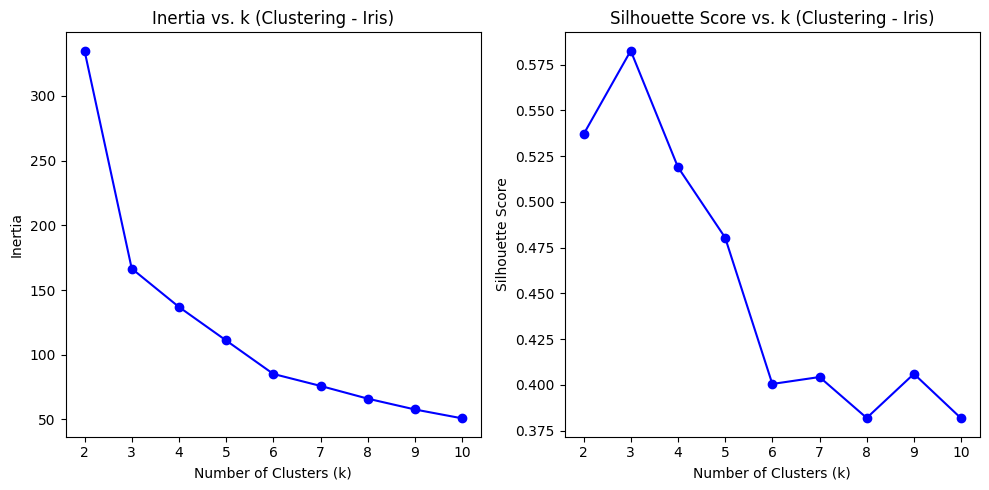


--- How do the inertia and silhouette scores change? ---
Inertia generally decreases as k increases. The rate of decrease diminishes.
Silhouette score typically increases to a peak and then decreases as k increases further.

--- What if you don't scale your features? ---


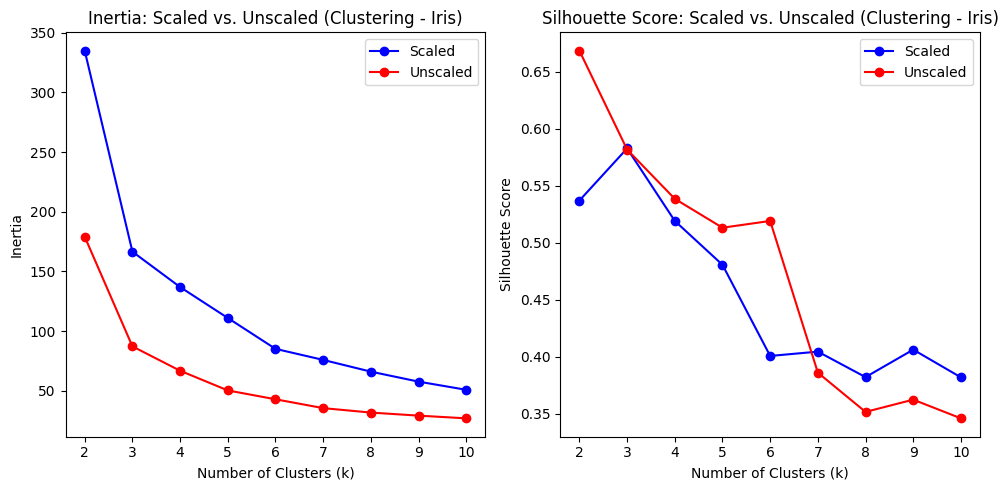


Without scaling, features with larger ranges might dominate the clustering process.

--- Is there a 'right' k? Why or why not? ---
For the Iris dataset, we can look at the inertia plot for an elbow (around k=3) and the silhouette score plot for a peak (also potentially around k=2 or k=3). The 'right' k often represents a balance between minimizing within-cluster variance and maximizing inter-cluster separation.
However, the 'right' k can also depend on the specific goals of the analysis. For the Iris dataset, knowing there are three species might guide us towards k=3, but purely data-driven metrics might suggest a slightly different number.


In [14]:
# --- Clustering Analysis (using the original Iris features) ---
print("\n--- Clustering Analysis ---")
df_cluster = df.drop(columns=['target'])
X_cluster = df_cluster.copy()
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Repeat the above exercise for different values of k
print("\n--- Clustering for Different Values of k ---")
inertia_values_cluster = []
silhouette_scores_cluster = []
k_values_cluster = range(2, 11)

for k in k_values_cluster:
    kmeans_cluster = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_cluster.fit(X_cluster_scaled)
    inertia_values_cluster.append(kmeans_cluster.inertia_)
    silhouette = silhouette_score(X_cluster_scaled, kmeans_cluster.labels_)
    silhouette_scores_cluster.append(silhouette)

# Plot Inertia vs. k for clustering
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values_cluster, inertia_values_cluster, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. k (Clustering - Iris)')

# Plot Silhouette Score vs. k for clustering
plt.subplot(1, 2, 2)
plt.plot(k_values_cluster, silhouette_scores_cluster, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k (Clustering - Iris)')

plt.tight_layout()
plt.show()

# How do the inertia and silhouette scores change?
print("\n--- How do the inertia and silhouette scores change? ---")
print("Inertia generally decreases as k increases. The rate of decrease diminishes.")
print("Silhouette score typically increases to a peak and then decreases as k increases further.")

# What if you don't scale your features?
print("\n--- What if you don't scale your features? ---")
inertia_unscaled_cluster = []
silhouette_unscaled_cluster = []

for k in k_values_cluster:
    kmeans_unscaled_cluster = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_unscaled_cluster.fit(X_cluster)
    inertia_unscaled_cluster.append(kmeans_unscaled_cluster.inertia_)
    silhouette_unscaled_cluster.append(silhouette_score(X_cluster, kmeans_unscaled_cluster.labels_))

# Plot comparison with and without scaling (Inertia - Clustering)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values_cluster, inertia_values_cluster, 'bo-', label='Scaled')
plt.plot(k_values_cluster, inertia_unscaled_cluster, 'ro-', label='Unscaled')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia: Scaled vs. Unscaled (Clustering - Iris)')
plt.legend()

# Plot comparison with and without scaling (Silhouette Score - Clustering)
plt.subplot(1, 2, 2)
plt.plot(k_values_cluster, silhouette_scores_cluster, 'bo-', label='Scaled')
plt.plot(k_values_cluster, silhouette_unscaled_cluster, 'ro-', label='Unscaled')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score: Scaled vs. Unscaled (Clustering - Iris)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nWithout scaling, features with larger ranges might dominate the clustering process.")

# Is there a 'right' k? Why or why not?
print("\n--- Is there a 'right' k? Why or why not? ---")
print("For the Iris dataset, we can look at the inertia plot for an elbow (around k=3) and the silhouette score plot for a peak (also potentially around k=2 or k=3). The 'right' k often represents a balance between minimizing within-cluster variance and maximizing inter-cluster separation.")
print("However, the 'right' k can also depend on the specific goals of the analysis. For the Iris dataset, knowing there are three species might guide us towards k=3, but purely data-driven metrics might suggest a slightly different number.")

## Repeating above exercises on food nutrients dataset

Logistic Regression

--- Logistic Regression Analysis ---

--- 1. Impact of Custom Thresholds ---
   Threshold  Accuracy  Precision   Recall
0        0.1  0.759259   0.711111  1.00000
1        0.2  0.833333   0.780488  1.00000
2        0.3  0.833333   0.794872  0.96875
3        0.4  0.851852   0.900000  0.84375
4        0.5  0.814815   0.892857  0.78125
5        0.6  0.796296   0.920000  0.71875
6        0.7  0.796296   0.920000  0.71875
7        0.8  0.796296   0.956522  0.68750
8        0.9  0.722222   1.000000  0.53125

--- 2. Analysis for Other Columns (Individual Features) ---

--- Analyzing feature: alcohol ---
   Threshold  Accuracy  Precision   Recall
0        0.1  0.870370   0.820513  1.00000
1        0.2  0.925926   0.888889  1.00000
2        0.3  0.981481   0.969697  1.00000
3        0.4  0.981481   0.969697  1.00000
4        0.5  1.000000   1.000000  1.00000
5        0.6  0.962963   1.000000  0.93750
6        0.7  0.907407   1.000000  0.84375
7        0.8  0.888889   1.000000  0.81250
8        

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   Threshold  Accuracy  Precision   Recall
0        0.1  0.592593   0.592593  1.00000
1        0.2  0.592593   0.592593  1.00000
2        0.3  0.592593   0.592593  1.00000
3        0.4  0.592593   0.592593  1.00000
4        0.5  0.500000   0.666667  0.31250
5        0.6  0.407407   0.500000  0.03125
6        0.7  0.407407   0.000000  0.00000
7        0.8  0.407407   0.000000  0.00000
8        0.9  0.407407   0.000000  0.00000

--- Analyzing feature: ash ---
   Threshold  Accuracy  Precision   Recall
0        0.1  0.592593   0.592593  1.00000
1        0.2  0.592593   0.592593  1.00000
2        0.3  0.574074   0.588235  0.93750
3        0.4  0.648148   0.638298  0.93750
4        0.5  0.574074   0.680000  0.53125
5        0.6  0.425926   1.000000  0.03125
6        0.7  0.407407   0.000000  0.00000
7        0.8  0.407407   0.000000  0.00000
8        0.9  0.407407   0.000000  0.00000

--- Analyzing feature: alcalinity_of_ash ---
   Threshold  Accuracy  Precision   Recall
0        0.1  0.592

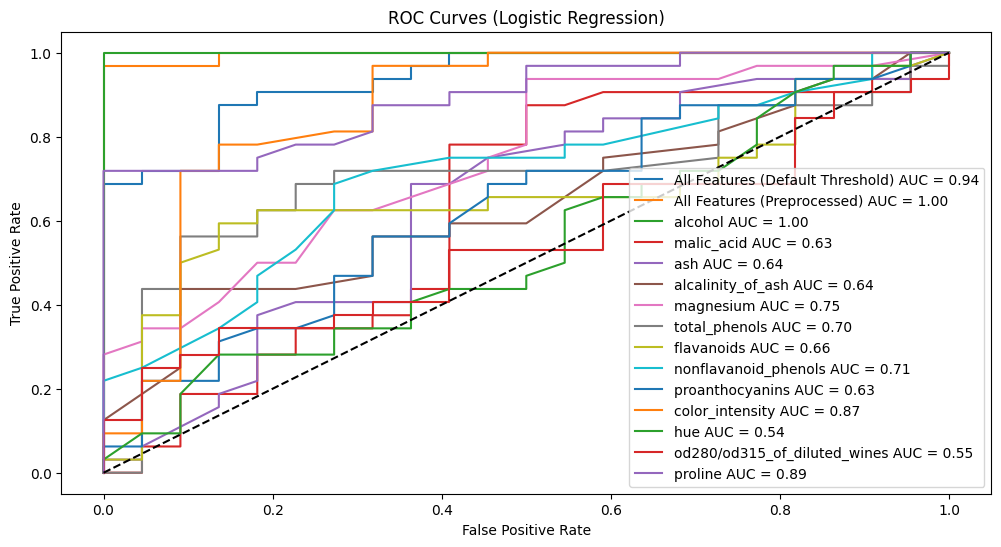


--- Food Nutrients Dataset Analysis ---


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine # Using a sample dataset for demonstration

# --- Load a sample dataset for Logistic Regression (replace with your actual data) ---
print("--- Logistic Regression Analysis ---")
wine = load_wine(as_frame=True)
df = wine.frame
# For demonstration, let's create a binary target variable (e.g., if alcohol > 13, class 1, else class 0)
df['high_alcohol'] = (df['alcohol'] > 13).astype(int)
X_lr = df.drop(columns=['target', 'high_alcohol'])
y_lr = df['high_alcohol']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=42)

# --- 1. Impact of Custom Thresholds (Logistic Regression) ---
print("\n--- 1. Impact of Custom Thresholds ---")
model_default_lr = LogisticRegression()
model_default_lr.fit(X_train_lr, y_train_lr)
probabilities_default_lr = model_default_lr.predict_proba(X_test_lr)[:, 1]

thresholds_lr = np.arange(0.1, 1, 0.1)
results_thresholds_lr = []
for threshold in thresholds_lr:
    predictions_lr = (probabilities_default_lr >= threshold).astype(int)
    accuracy_lr = accuracy_score(y_test_lr, predictions_lr)
    precision_lr = precision_score(y_test_lr, predictions_lr, zero_division=0)
    recall_lr = recall_score(y_test_lr, predictions_lr, zero_division=0)
    results_thresholds_lr.append({
        'Threshold': threshold,
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr
    })

print(pd.DataFrame(results_thresholds_lr))

# --- 2. Analysis for Other Columns (Individual Features - Logistic Regression) ---
print("\n--- 2. Analysis for Other Columns (Individual Features) ---")
for column in X_lr.columns:
    print(f"\n--- Analyzing feature: {column} ---")
    X_single_lr = X_lr[[column]]
    X_train_single_lr, X_test_single_lr, y_train_single_lr, y_test_single_lr = train_test_split(
        X_single_lr, y_lr, test_size=0.3, random_state=42
    )
    model_single_lr = LogisticRegression()
    model_single_lr.fit(X_train_single_lr, y_train_single_lr)
    probabilities_single_lr = model_single_lr.predict_proba(X_test_single_lr)[:, 1]

    results_single_thresholds_lr = []
    for threshold in thresholds_lr:
        predictions_single_lr = (probabilities_single_lr >= threshold).astype(int)
        accuracy_single_lr = accuracy_score(y_test_single_lr, predictions_single_lr)
        precision_single_lr = precision_score(y_test_single_lr, predictions_single_lr, zero_division=0)
        recall_single_lr = recall_score(y_test_single_lr, predictions_single_lr, zero_division=0)
        results_single_thresholds_lr.append({
            'Threshold': threshold,
            'Accuracy': accuracy_single_lr,
            'Precision': precision_single_lr,
            'Recall': recall_single_lr
        })
    print(pd.DataFrame(results_single_thresholds_lr))

# --- 3. Logistic Regression Model on All Features (with Preprocessing) ---
print("\n--- 3. Logistic Regression Model on All Features (with Preprocessing) ---")
categorical_features_lr = X_lr.select_dtypes(include=['object']).columns
numerical_features_lr = X_lr.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer_lr = StandardScaler()
categorical_transformer_lr = OneHotEncoder(handle_unknown='ignore')

preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_lr, numerical_features_lr),
        ('cat', categorical_transformer_lr, categorical_features_lr)])

model_all_features_lr = Pipeline(steps=[('preprocessor', preprocessor_lr),
                                       ('classifier', LogisticRegression(solver='liblinear'))])

model_all_features_lr.fit(X_train_lr, y_train_lr)
y_pred_all_lr = model_all_features_lr.predict(X_test_lr)
probabilities_all_lr = model_all_features_lr.predict_proba(X_test_lr)[:, 1]
accuracy_all_lr = accuracy_score(y_test_lr, y_pred_all_lr)
precision_all_lr = precision_score(y_test_lr, y_pred_all_lr, zero_division=0)
recall_all_lr = recall_score(y_test_lr, y_pred_all_lr, zero_division=0)

print(f"Accuracy on all features (with preprocessing): {accuracy_all_lr:.4f}")
print(f"Precision on all features (with preprocessing): {precision_all_lr:.4f}")
print(f"Recall on all features (with preprocessing): {recall_all_lr:.4f}")

# --- 4. Plot ROC Curves for Each Model (Logistic Regression) ---
print("\n--- 4. Plot ROC Curves for Each Model ---")
plt.figure(figsize=(12, 6))

# ROC for model with default threshold on all features
fpr_all_default_lr, tpr_all_default_lr, _ = roc_curve(y_test_lr, model_default_lr.predict_proba(X_test_lr)[:, 1])
auc_all_default_lr = roc_auc_score(y_test_lr, model_default_lr.predict_proba(X_test_lr)[:, 1])
plt.plot(fpr_all_default_lr, tpr_all_default_lr, label=f'All Features (Default Threshold) AUC = {auc_all_default_lr:.2f}')

# ROC for model on all features with preprocessing
fpr_all_processed_lr, tpr_all_processed_lr, _ = roc_curve(y_test_lr, probabilities_all_lr)
auc_all_processed_lr = roc_auc_score(y_test_lr, probabilities_all_lr)
plt.plot(fpr_all_processed_lr, tpr_all_processed_lr, label=f'All Features (Preprocessed) AUC = {auc_all_processed_lr:.2f}')

# ROC curves for individual features
for column in X_lr.columns:
    X_single_lr = X_lr[[column]]
    X_train_single_lr, X_test_single_lr, y_train_single_lr, y_test_single_lr = train_test_split(
        X_single_lr, y_lr, test_size=0.3, random_state=42
    )
    model_single_lr = LogisticRegression()
    model_single_lr.fit(X_train_single_lr, y_train_single_lr)
    probabilities_single_lr = model_single_lr.predict_proba(X_test_single_lr)[:, 1]
    fpr_single_lr, tpr_single_lr, _ = roc_curve(y_test_single_lr, probabilities_single_lr)
    auc_single_lr = roc_auc_score(y_test_single_lr, probabilities_single_lr)
    plt.plot(fpr_single_lr, tpr_single_lr, label=f'{column} AUC = {auc_single_lr:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Logistic Regression)')
plt.legend()
plt.show()

# --- Food Nutrients Dataset Analysis ---
print("\n--- Food Nutrients Dataset Analysis ---")

# --- Load a sample food nutrients dataset (replace with your actual data) ---
# For demonstration, let's create a synthetic dataset
np.random.seed(42)
n_samples_food = 100
food_data = {
    'Calories': np.random.randint(50, 800, n_samples_food),
    'Protein': np.random.uniform(1, 50, n_samples_food),
    'Fat': np.random.uniform(0, 80, n_samples_food),
    'Carbs': np.random.uniform(5, 100, n_samples_food),
    'Fiber': np.random.uniform(0, 15, n_samples_food),
    'VitaminA': np.random.randint(0, 5000, n_samples_food),
    'VitaminC': np.random.randint(0, 100, n_samples_food),
    'Calcium': np.random.randint(0, 1000, n_samples_food),
    'Iron': np.random.uniform(0, 20, n_samples_food)
}
food_df = pd.DataFrame(food_data)
X_food = food_df.copy()
X_food_scaled = StandardScaler().fit_transform(X_food)



## Clustering


--- Clustering for Different Values of k (Food Nutrients) ---


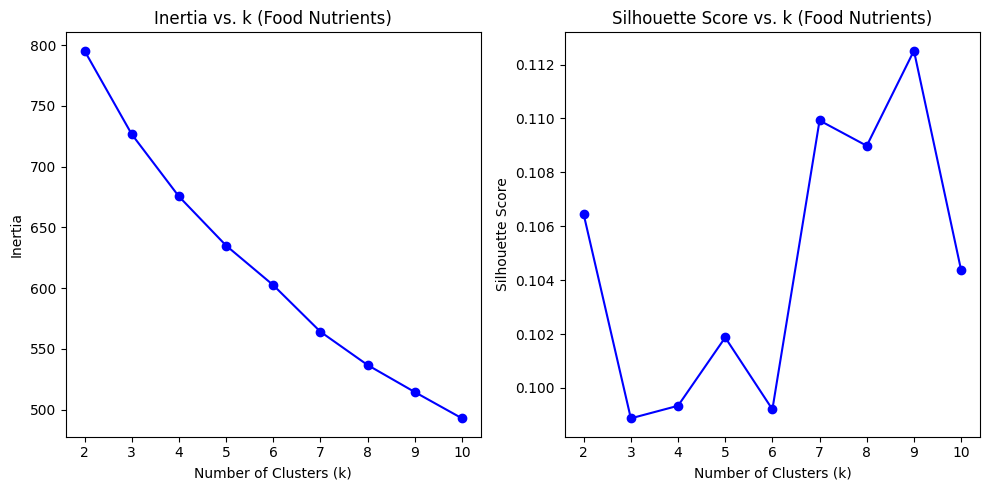


--- How do the inertia and silhouette scores change? (Food Nutrients) ---
Inertia generally decreases as k increases. The rate of decrease typically diminishes.
Silhouette score often increases to a peak, indicating better-defined clusters, and then decreases as k becomes too large.

--- What if you don't scale your features? (Food Nutrients) ---


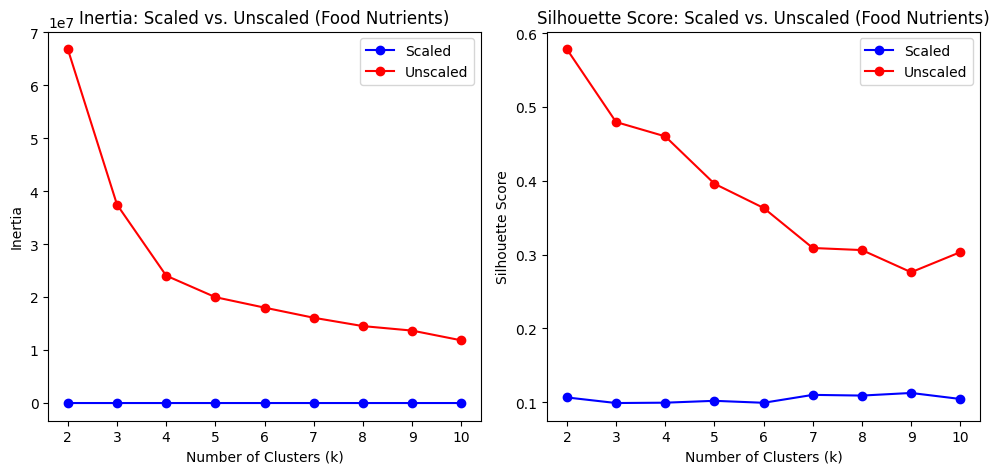


Without scaling, features with larger ranges (e.g., Calories, VitaminA, Calcium) dominate the distance calculations in K-Means for the food nutrients data. This can lead to clusters that are primarily based on these high-magnitude features, potentially ignoring patterns in features with smaller ranges (e.g., Protein, Fat, Iron). The inertia and silhouette scores will also be influenced by this dominance, potentially leading to a different 'optimal' k compared to when the data is scaled.

--- Is there a 'right' k? Why or why not? (Food Nutrients) ---
For the food nutrients dataset, determining the 'right' k involves analyzing the inertia plot for an 'elbow' and the silhouette score plot for a peak. However, the interpretation can be subjective.
The 'best' k might depend on the desired level of granularity in grouping food items based on their nutrient profiles. For example, a smaller k might group foods into broad categories (e.g., 'high calorie', 'low calorie'), while a larger k could

In [16]:
# --- Clustering for Different Values of k (Food Nutrients) ---
print("\n--- Clustering for Different Values of k (Food Nutrients) ---")
inertia_values_food = []
silhouette_scores_food = []
k_values_food = range(2, 11)

for k in k_values_food:
    kmeans_food = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_food.fit(X_food_scaled)
    inertia_values_food.append(kmeans_food.inertia_)
    silhouette = silhouette_score(X_food_scaled, kmeans_food.labels_)
    silhouette_scores_food.append(silhouette)

# Plot Inertia vs. k for food data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values_food, inertia_values_food, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. k (Food Nutrients)')

# Plot Silhouette Score vs. k for food data
plt.subplot(1, 2, 2)
plt.plot(k_values_food, silhouette_scores_food, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k (Food Nutrients)')

plt.tight_layout()
plt.show()

# --- How do the inertia and silhouette scores change? (Food Nutrients) ---
print("\n--- How do the inertia and silhouette scores change? (Food Nutrients) ---")
print("Inertia generally decreases as k increases. The rate of decrease typically diminishes.")
print("Silhouette score often increases to a peak, indicating better-defined clusters, and then decreases as k becomes too large.")

# --- What if you don't scale your features? (Food Nutrients) ---
print("\n--- What if you don't scale your features? (Food Nutrients) ---")
inertia_unscaled_food = []
silhouette_unscaled_food = []

for k in k_values_food:
    kmeans_unscaled_food = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_unscaled_food.fit(X_food)
    inertia_unscaled_food.append(kmeans_unscaled_food.inertia_)
    silhouette_unscaled_food.append(silhouette_score(X_food, kmeans_unscaled_food.labels_))

# Plot comparison with and without scaling (Inertia - Food)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values_food, inertia_values_food, 'bo-', label='Scaled')
plt.plot(k_values_food, inertia_unscaled_food, 'ro-', label='Unscaled')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia: Scaled vs. Unscaled (Food Nutrients)')
plt.legend()

# Plot comparison with and without scaling (Silhouette Score - Food)
plt.subplot(1, 2, 2)
plt.plot(k_values_food, silhouette_scores_food, 'bo-', label='Scaled')
plt.plot(k_values_food, silhouette_unscaled_food, 'ro-', label='Unscaled')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score: Scaled vs. Unscaled (Food Nutrients)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nWithout scaling, features with larger ranges (e.g., Calories, VitaminA, Calcium) dominate the distance calculations in K-Means for the food nutrients data. This can lead to clusters that are primarily based on these high-magnitude features, potentially ignoring patterns in features with smaller ranges (e.g., Protein, Fat, Iron). The inertia and silhouette scores will also be influenced by this dominance, potentially leading to a different 'optimal' k compared to when the data is scaled.")

# --- Is there a 'right' k? Why or why not? (Food Nutrients) ---
print("\n--- Is there a 'right' k? Why or why not? (Food Nutrients) ---")
print("For the food nutrients dataset, determining the 'right' k involves analyzing the inertia plot for an 'elbow' and the silhouette score plot for a peak. However, the interpretation can be subjective.")
print("The 'best' k might depend on the desired level of granularity in grouping food items based on their nutrient profiles. For example, a smaller k might group foods into broad categories (e.g., 'high calorie', 'low calorie'), while a larger k could identify more specific sub-groups.")
print("The inherent structure of the nutrient data might not have perfectly distinct clusters, making it challenging to pinpoint a single 'correct' k. Domain knowledge about food groups and nutritional similarities could also inform the choice of k.")